# Locally Weighted Linear Regression from Scratch

This notebook implements **Locally Weighted Linear Regression (LWLR)** — a non-parametric, memory-based algorithm — as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 3)** by Andrew Ng.

It includes:
- Feature normalization using Z-score
- Gaussian kernel-based weighting of training examples
- Instance-wise predictions without explicit parameter learning
- Performance visualization using scatter 

> 📘 This is part of the broader `ml-from-scratch` project — a hands-on initiative to implement core ML algorithms using only **NumPy** and **pandas**, reinforcing theoretical concepts taught in CS229.


In [2]:
import pickle
import numpy as np
from typing import List
import pandas as pd
from numpy import ndarray
import matplotlib.pyplot as plt


In [3]:
class LocallyWeightedLR:
    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std: ndarray = None
        self.y_mean: ndarray = None
        self.y_std: ndarray = None
        self.x_norm: ndarray = None
        self.y_norm: ndarray = None
        self.is_norm: bool = False

    @staticmethod
    def h(x: ndarray, theta: ndarray) -> ndarray:
        return np.dot(x, theta)

    @staticmethod
    def W(x_query: ndarray, x_norm: ndarray, tau: float) -> ndarray:
        diff = x_norm - x_query
        distance = np.sum(np.square(diff), axis=1)
        weights = np.exp(-distance / (2 * tau ** 2))
        return np.diag(weights)

    @staticmethod
    def J(x: ndarray, y: ndarray, theta: ndarray, weight: ndarray) -> float:
        error = LocallyWeightedLR.h(x, theta) - y
        return np.sum(np.square(weight @ error))

    @staticmethod
    def add_bias(x: ndarray) -> ndarray:
        return np.hstack((np.ones((x.shape[0], 1)), x))

    def normalize(self, x_train: ndarray, y_train: ndarray, add_bias=True):
        self.x_mean = x_train.mean(axis=0)
        self.x_std = x_train.std(axis=0)
        self.y_mean = y_train.mean(axis=0)
        self.y_std = y_train.std(axis=0)

        self.x_std[self.x_std == 0] = 1  # Avoid divide-by-zero
        self.y_std[self.y_std == 0] = 1

        self.x_norm = (x_train - self.x_mean) / self.x_std
        self.y_norm = (y_train - self.y_mean) / self.y_std

        if add_bias:
            self.x_norm = self.add_bias(self.x_norm)

        self.is_norm = True
        return self.x_norm, self.y_norm, self.x_mean, self.x_std, self.y_mean, self.y_std

    def predict(self, x_train: ndarray, y_train: ndarray, x_query: ndarray, tau: float, add_bias=True):
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)

        x_query_norm = (x_query - self.x_mean) / self.x_std
        if add_bias:
            x_query_norm = np.concatenate([[1], x_query_norm])

        w = self.W(x_query_norm, self.x_norm, tau)
        XtWX = self.x_norm.T @ w @ self.x_norm
        XtWY = self.x_norm.T @ w @ self.y_norm
        theta = np.linalg.pinv(XtWX) @ XtWY

        loss = self.J(self.x_norm, self.y_norm, theta, w)
        pred = self.h(x_query_norm, theta)
        y_pred = (pred * self.y_std) + self.y_mean

        return y_pred, loss, theta, w

    def save(self, filepath: str) -> None:
        data = {
            "x_mean": self.x_mean,
            "x_std": self.x_std,
            "x_norm": self.x_norm,
            "y_mean": self.y_mean,
            "y_std": self.y_std,
            "y_norm": self.y_norm,
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

    class Loader:
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)

            self.x_mean = data["x_mean"]
            self.x_std = data["x_std"]
            self.x_norm = data["x_norm"]
            self.y_mean = data["y_mean"]
            self.y_std = data["y_std"]
            self.y_norm = data["y_norm"]

        def predict(self, x_query: List[float], tau: float, add_bias: bool = True):
            x_query = np.array(x_query, dtype=float)
            x_query_norm = (x_query - self.x_mean) / self.x_std
            if add_bias:
                x_query_norm = np.concatenate([[1], x_query_norm])

            w = LocallyWeightedLR.W(x_query_norm, self.x_norm, tau)
            XtWX = self.x_norm.T @ w @ self.x_norm
            XtWY = self.x_norm.T @ w @ self.y_norm
            theta = np.linalg.pinv(XtWX) @ XtWY

            loss = LocallyWeightedLR.J(self.x_norm, self.y_norm, theta, w)
            pred = LocallyWeightedLR.h(x_query_norm, theta)
            y_pred = (pred * self.y_std) + self.y_mean

            return y_pred, loss, theta, w


In [4]:
data = pd.read_csv("./data/ds5_train.csv")
print(data.isnull().sum())
data.head()

x_1    0
y      0
dtype: int64


,x_1,y
0,-4.029750,-0.420076
1,-2.524577,0.205268
2,2.794617,0.773794
3,1.695904,0.210476
4,-1.458392,0.858475


In [8]:
x_train = data[["x_1"]].values
y_train = data[["y"]].values

In [12]:
model = LocallyWeightedLR()

pred, _, _, _ = model.predict(x_train, y_train, [-2.524577], 0.05)
pred

array([0.0787479])

In [13]:
model.save("./localparam.pkl")

In [15]:
inference = LocallyWeightedLR.Loader("./localparam.pkl")
pred, _, _, _ = inference.predict([-2.524577], 0.05)
pred

array([0.0787479])

In [20]:
m = x_train.shape[0]
preds = []
for i in range(m):
    pred, _, _, _ = inference.predict(x_train[i], 0.05)
    preds.append(pred)

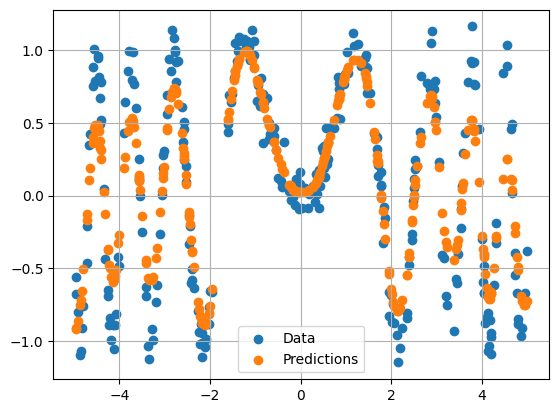

In [21]:
plt.scatter(x_train, y_train, label='Data')
plt.scatter(x_train, preds, label='Predictions')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
val = pd.read_csv("./data/ds5_valid.csv")
x_val = val[["x_1"]].values
y_val = val[["y"]].values

test = pd.read_csv("./data/ds5_test.csv")
x_test = test[["x_1"]].values
y_test = test[["y"]].values

In [24]:
m = x_val.shape[0]
preds = []
for i in range(m):
    pred, _, _, _ = inference.predict(x_val[i], 0.05)
    preds.append(pred)

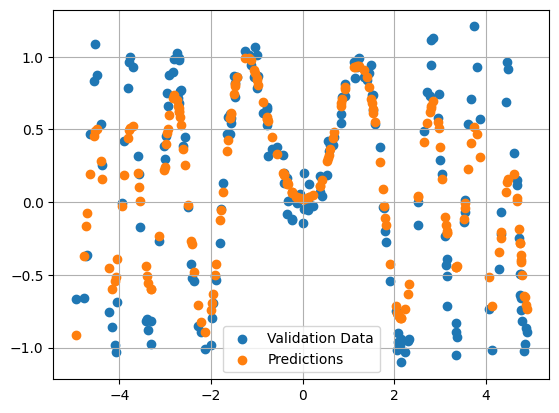

In [25]:
plt.scatter(x_val, y_val, label='Validation Data')
plt.scatter(x_val, preds, label='Predictions')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
m = x_test.shape[0]
preds = []
for i in range(m):
    pred, _, _, _ = inference.predict(x_test[i], 0.05)
    preds.append(pred)

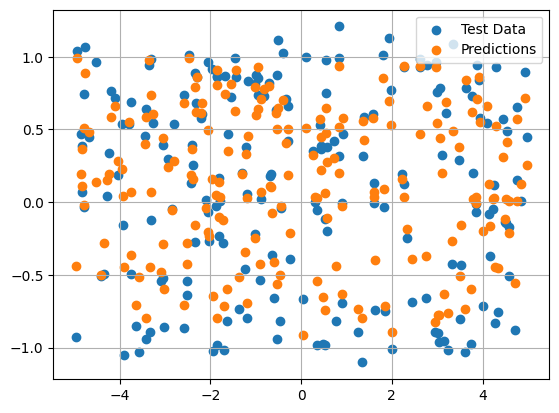

In [27]:
plt.scatter(x_test, y_val, label='Test Data')
plt.scatter(x_test, preds, label='Predictions')
plt.grid(True)
plt.legend()
plt.show()